In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

### Data


Load data and make sure everything is ok

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Prep the datasets
trainset = datasets.MNIST('MnistData', download=True, train=True, transform=transform)
valset = datasets.MNIST('MnistData', download=True, train=False, transform=transform)

# Feeding for a NN
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

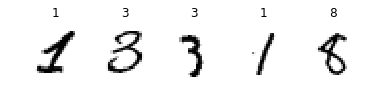

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

visualize = 5
plt.figure()
for i in range(visualize):
    plt.subplot(1, visualize, i + 1)
    plt.title(labels[i].data.tolist())
    plt.axis('off')
    plt.imshow(images[i].numpy().reshape(28,28), cmap="gray_r")

### Network

Define a standard FFN and train it to some extend for testing

In [4]:
class mnistnet(nn.Module):
    
    def __init__(self, input_size, hidden1, hidden2, output_size):
        super(mnistnet, self).__init__()
        # Define the layers
        self.fl1 = nn.Linear(input_size, hidden1)
        self.fl2 = nn.Linear(hidden1, hidden2)
        self.fl3 = nn.Linear(hidden2, output_size)
        self.out = nn.LogSoftmax(dim=1)
        
    # Forward pass
    def forward(self, x):
        x = F.relu(self.fl1(x))
        x = F.relu(self.fl2(x))
        x = self.fl3(x)
        return self.out(x)
        

In [5]:
my_network = mnistnet(28*28, 64, 32, 10)

In [24]:
optimizer = optim.SGD(my_network.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

losses = []
for epoch in range(25):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        output = my_network.forward(images.view(images.shape[0], -1))
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    print("\rEpoch {} loss {}".format(epoch+1,running_loss), end="")
    


Epoch 25 loss 39.05735955759883

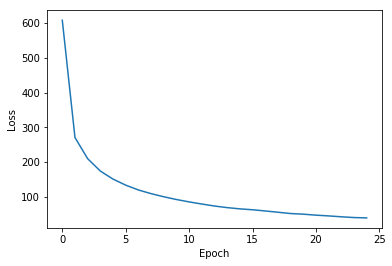

In [25]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.show()

### Explainability 

Use gradient (times) input for the easiest way to see what the network pays attention to

$R = \triangledown f(x) * x$

* We can use gradients from pytorch to highlight relevant pixels
* Easy to implement method
* degenerates with deeper networks

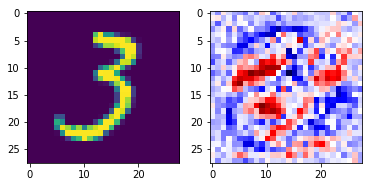

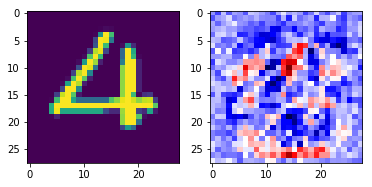

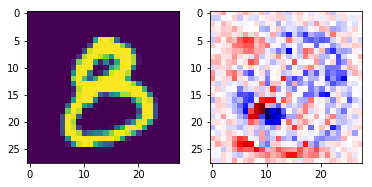

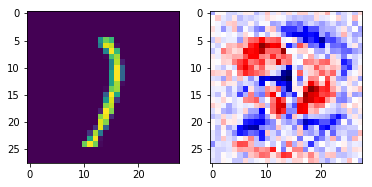

In [28]:
# Decide x examples
for i in range(1,5):
    test_input = images[i].view(1, -1)
    test_input.requires_grad = True
    
    # To find relevant pixels, we need to only focus on the true output
    one_hot_target = torch.zeros(10)
    one_hot_target[labels[i]] = 1
    
    # To find the gradient, we use autograd
    loss = (my_network(test_input) * one_hot_target).sum()
    loss.backward()
    plt.figure()
    R = (test_input.data * test_input.grad).detach().numpy().reshape(28,28)
    
    # Plot output
    plt.subplot(1,2,1)
    plt.imshow(test_input.detach().reshape(28,28).numpy())
    plt.subplot(1,2,2)
    plt.imshow(R.reshape(28, 28), cmap="seismic")

### Conclusions

In the images

* Red pixels: 
* Blue pixels:  

are used to make ultimate decisions

In [30]:
R[8,8]

0.0843102